In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
import cmath
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [2]:
def nc(x):
    x = x.astype(float)
    return (x-np.mean(x))/np.std(x)

In [3]:
def Spike_Time_Generater(rdt, dt, Garmma=1):
    rdt = rdt*Garmma
    Spike_time = []
    
    counter = 0
    post_remainer_c = 0
    p = 1
    while True:
        the_random_number = 1-np.random.rand()
        while (the_random_number < p and counter < len(rdt)):
            p *= np.exp(-rdt[counter])
            counter += 1
        if counter >= len(rdt):
            break
        remainer_c = -np.log(p/the_random_number)/rdt[counter-1]
#         if remainer_c>=1 or remainer_c<=0:
#             print('shit!')
        Spike_time.append(dt*(counter-remainer_c))
        p = np.exp(-remainer_c*rdt[counter-1])
    return Spike_time[::Garmma]

# activation function
def NL(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

In [4]:
# exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408'
# Fc_list = [2,4,7,10]
# annots_list = []
# for Fc in Fc_list:
#     annots_list.append(loadmat(exp_folder+'\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2'))
    
# dt = 0.01
# sampling_rate = 20000
# x_list, v_list, t_cor_list, T_list = [], [], [], []
# for annots in annots_list:
#     TimeStamps =np.round(np.squeeze(annots['TimeStamps']))
#     TimeStamps = TimeStamps.astype(int)
#     x = annots['a_data'][0, TimeStamps[0]*sampling_rate:TimeStamps[1]*sampling_rate+1]
#     x = ndimage.gaussian_filter1d(x, sigma=int(sampling_rate*dt/2), mode='reflect') / dt
#     x = x[::int(sampling_rate*dt)]
#     x = x.astype(float)
#     x = (x -np.mean(x))/np.std(x)
#     T = np.arange(1,len(x)+1)*dt
#     v = np.append(0,np.diff(x))/dt
    
#     x_list.append(x.copy())
#     v_list.append(v.copy())
#     T_list.append(T.copy())
#     x_cor = np.correlate(x, x, "same")
#     x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
#     Taxis = np.flip(T[:len(x_cor)]-dt*3/2)
#     t_cor_list.append(np.interp(0.5*max(x_cor),  x_cor, Taxis))

In [19]:
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
# OU ; input
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
cutoffFreq = 5
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

In [20]:
Lambda = 0.95
beta = (1-Lambda)/Lambda

x = nc(LPOU)
v = np.append(0,np.diff(x))/dt
tv = ndimage.gaussian_filter1d(x, sigma=5, order=1, mode='reflect') / dt
r = (1-Lambda)*x+Lambda*v

k = 1.
alpha = 20.
g = 920.
phi = 1.
y=np.zeros(len(T))
z=np.zeros(len(T))
for j in range(len(T)-1):
    dy=dt*(-alpha*y[j]+k*(x[j]-phi*z[j]))
    dz=dt*(-beta*z[j]+g*y[j])
    y[j+1]=y[j]+dy
    z[j+1]=z[j]+dz

(250, 251)

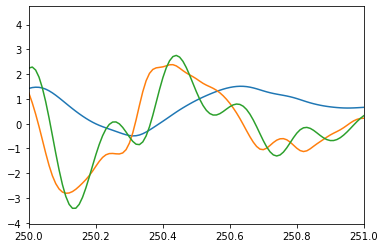

In [7]:
plt.plot(T,x)
plt.plot(T,nc(r))
plt.plot(T,nc(y))
# plt.plot(T,nc(v))
plt.xlim([250,251])

In [8]:
nr = NL(np.mean(y)-y, 0)
ratio = sum(nr)/T[-1]/12
FakeSpike = Spike_Time_Generater(nr/ratio, dt, 10)
rstate, _ = np.histogram(FakeSpike, np.append(0,T))

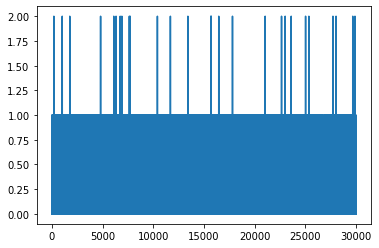

In [9]:
plt.plot(rstate)

In [21]:
lambdas = np.arange(0.1,0.9,0.1)
betas = (1-lambdas)/lambdas

(-10, 1)

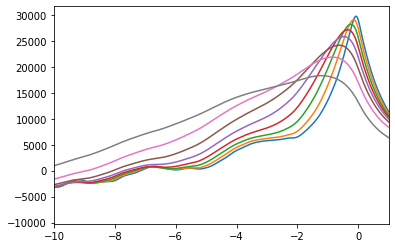

In [11]:
time_dis3 = []
for beta in betas:
    g = 1
    zs = []
    z = 0
    xs = LPOU-min(LPOU)
    for x in xs:
        dz = (-beta*z+g*x)*dt
        z = z+dz
        zs.append(z)
    zs = np.array(zs)
    xzCor = np.correlate(nc(xs),nc(zs), 'same')
    plt.plot(T-np.mean(T), xzCor)
    time_dis3.append((T-np.mean(T))[np.argmax(xzCor)])
plt.xlim([-10, 1])

(-10, 1)

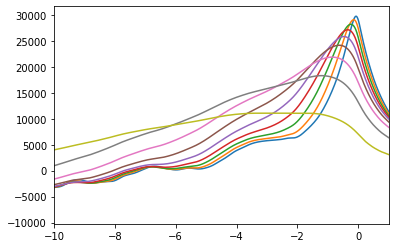

In [12]:
lambdas = np.arange(0.1,1,0.1)
betas = (1-lambdas)/lambdas
time_dis4 = []
for beta in betas:
    zs = []
    z = 0
    xs = LPOU-min(LPOU)
    for x in xs:
        dz = (-beta*z+g*x)*dt
        z = z+dz
        zs.append(z)
    zs = np.array(zs)
    xzCor = np.correlate(nc(xs),nc(zs), 'same')
    plt.plot(T-np.mean(T), xzCor)
    time_dis4.append((T-np.mean(T))[np.argmax(xzCor)])
plt.xlim([-10, 1])

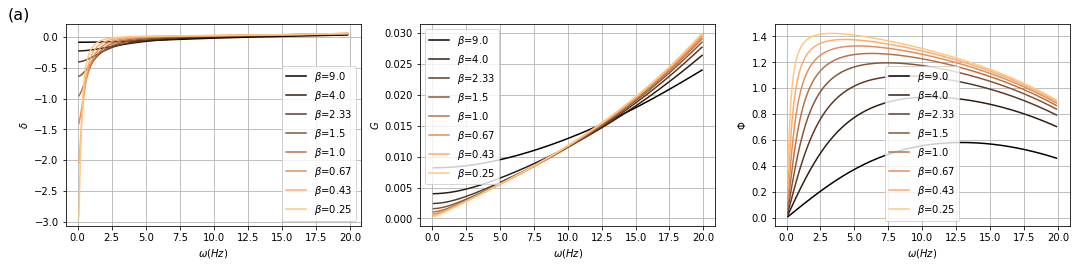

In [22]:
dOmega = 0.1
fig, ax = plt.subplots(nrows =1, ncols =3)
for axi in ax:
    axi.set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(betas)))))
    axi.set_xlabel(r'$\omega (Hz)$')
    axi.grid()
for beta in betas:
    omega = np.arange(dOmega,20,dOmega)
    H = k/(omega*1j+alpha+(k*phi*g/(omega*1j+beta)))#/(omega*1j)
    G = np.abs(H)
    Phi = np.angle(H)
    delta = -np.append(np.diff(Phi),0)/dOmega
    
    delta_phase = -(Phi-np.pi/2)/omega
    
    ax[0].plot(omega[:-1], delta[:-1])
    ax[0].set_ylabel(r'$\delta$')
    ax[1].plot(omega,G)
    ax[1].set_ylabel(r'$G$')
    ax[2].plot(omega,Phi)
    ax[2].set_ylabel(r'$\Phi$')
for axi in ax:
    axi.legend( [r'$\beta$='+str(round(beta,2)) for beta in betas], loc='best')
fig.text(0.08,0.9,'(a)', fontsize = 16)
fig.set_size_inches(18,3*(np.sqrt(5)-1))

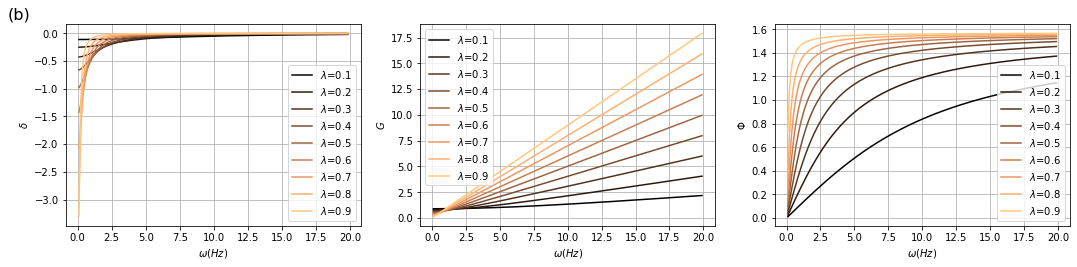

In [14]:
dOmega = 0.1
fig, ax = plt.subplots(nrows =1, ncols =3)
for axi in ax:
    axi.set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(betas)))))
    axi.set_xlabel(r'$\omega (Hz)$')
    axi.legend( [str(round(Lambda,2)) for Lambda in lambdas], loc='best')
    axi.grid()
for Lambda in lambdas:
    omega = np.arange(dOmega,20,dOmega)
    H = (1-Lambda+Lambda*1j*omega)#/(omega*1j)
    G = np.abs(H)
    Phi = np.angle(H)
    delta = -np.append(np.diff(Phi),0)/dOmega
    delta_phase = -(Phi)/omega
    
    ax[0].plot(omega[:-1], delta[:-1])
    ax[0].set_ylabel(r'$\delta$')
    ax[1].plot(omega,G)
    ax[1].set_ylabel(r'$G$')
    ax[2].plot(omega,Phi)
    ax[2].set_ylabel(r'$\Phi$')
    
for axi in ax:
    axi.legend( [r'$\lambda$='+str(round(Lambda,2)) for Lambda in lambdas], loc='best')
fig.text(0.08,0.9,'(b)', fontsize = 16)
fig.set_size_inches(18,3*(np.sqrt(5)-1))

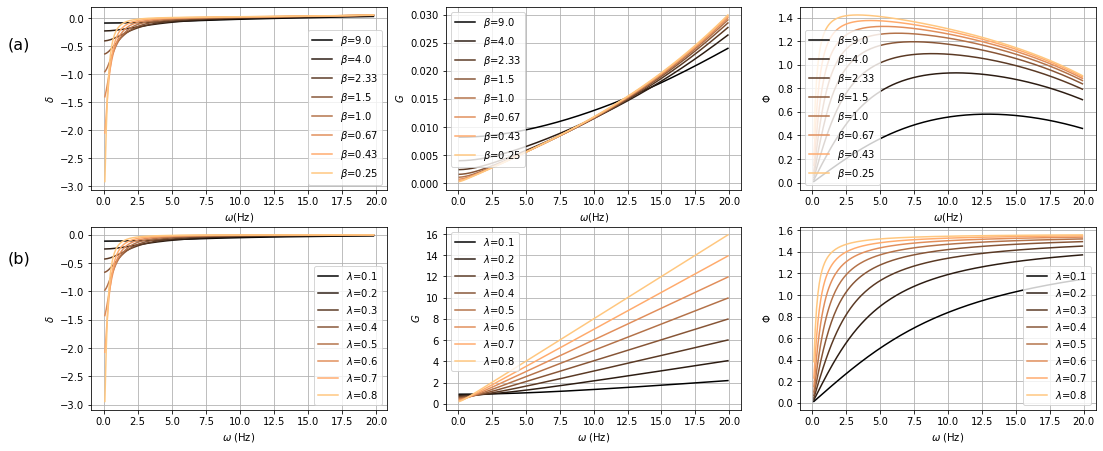

In [23]:
dOmega = 0.1
fig, (axup, axdown) = plt.subplots(nrows =2, ncols =3)
for axi in axup:
    axi.set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(betas)))))
    axi.set_xlabel(r'$\omega$(Hz)')
    axi.grid()
for axi in axdown:
    axi.set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(betas)))))
    axi.set_xlabel(r'$\omega$ (Hz)')
    axi.grid()
    
for beta in betas:
    omega = np.arange(dOmega,20,dOmega)
    H = k/(omega*1j+alpha+(k*phi*g/(omega*1j+beta)))#/(omega*1j)
    G = np.abs(H)
    Phi = np.angle(H)
    delta = -np.append(np.diff(Phi),0)/dOmega
    
    delta_phase = -(Phi-np.pi/2)/omega
    
    axup[0].plot(omega[:-1], delta[:-1])
    axup[0].set_ylabel(r'$\delta$')
    axup[1].plot(omega,G)
    axup[1].set_ylabel(r'$G$')
    axup[2].plot(omega,Phi)
    axup[2].set_ylabel(r'$\Phi$')
for axi in axup:
    axi.legend( [r'$\beta$='+str(round(beta,2)) for beta in betas], loc='best')
# fig.text(0.08,0.9,'(a)', fontsize = 16)

for Lambda in lambdas:
    omega = np.arange(dOmega,20,dOmega)
    H = (1-Lambda+Lambda*1j*omega)#/(omega*1j)
    G = np.abs(H)
    Phi = np.angle(H)
    delta = -np.append(np.diff(Phi),0)/dOmega
    delta_phase = -(Phi)/omega
    
    axdown[0].plot(omega[:-1], delta[:-1])
    axdown[0].set_ylabel(r'$\delta$')
    axdown[1].plot(omega,G)
    axdown[1].set_ylabel(r'$G$')
    axdown[2].plot(omega,Phi)
    axdown[2].set_ylabel(r'$\Phi$')
    
for axi in axdown:
    axi.legend( [r'$\lambda$='+str(round(Lambda,2)) for Lambda in lambdas], loc='best')
fig.text(0.06,0.8,'(a)', fontsize = 16)
fig.text(0.06,0.4,'(b)', fontsize = 16)
fig.set_size_inches(18,6*(np.sqrt(5)-1))
# fig.savefig('D:\\GoogleDrive\\retina\\PID_paper\\HeuristicVSNGD_FreqDomain_Props.jpeg')

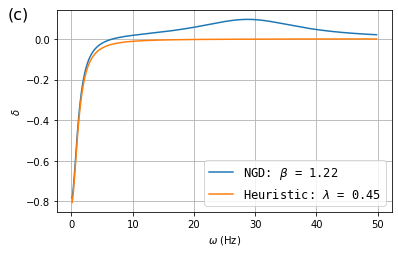

In [24]:
dOmega = 0.1
Lambda = 0.45
beta = (1-Lambda)/Lambda
omega = np.arange(dOmega,50,dOmega)
H = k/(omega*1j+alpha+(k*phi*g/(omega*1j+beta)))#/(omega*1j)
G = np.abs(H)
Phi = np.angle(H)
NGD_delta = -np.append(np.diff(Phi),0)/dOmega


H = (1-Lambda+Lambda*1j*omega)#/(omega*1j)
G = np.abs(H)
Phi = np.angle(H)
xv_delta = -np.append(np.diff(Phi),0)/dOmega

fig, ax = plt.subplots()
ax.plot(omega[:-1], NGD_delta[:-1])
ax.plot(omega[:-1], xv_delta[:-1])
ax.set_ylabel(r'$\delta$')
ax.set_xlabel(r'$\omega$ (Hz)')
ax.legend( (r'NGD: $\beta$ = '+str(round(beta, 2)), 'Heuristic: $\lambda$ = '+str(round(Lambda, 2)))
          , loc='best',prop={'size': 'large', 'family': 'monospace'})
ax.grid()
fig.text(0.01,0.85,'(c)', fontsize = 16)
fig.set_size_inches(6,3*(np.sqrt(5)-1))
fig.savefig('D:\\GoogleDrive\\retina\\PID_paper\\HeuristicVSNGD_FreqDomain_Props_onefig.jpeg')

In [25]:
import pandas as pd
data = {}
data['omega']=omega[:-1]
data['NGD_delta']=NGD_delta[:-1]
data['xv_delta']=xv_delta[:-1]

data_df = pd.DataFrame(data)
# data = np.arange(1,101).reshape((10,10))
# data_df = pd.DataFrame(data)
 
# # change the index and column name
# data_df.columns = ['A','B','C','D','E','F','G','H','I','J']
# data_df.index = ['a','b','c','d','e','f','g','h','i','j']
 
# create and writer pd.DataFrame to excel
name  = 'deltaVSomega'
writer = pd.ExcelWriter('D:\\GoogleDrive\\retina\\PID_paper\\For Origin Plot\\'+name+'.xlsx')
data_df.to_excel(writer,'page_1',float_format='%.5f') # float_format 控制精度
writer.save()

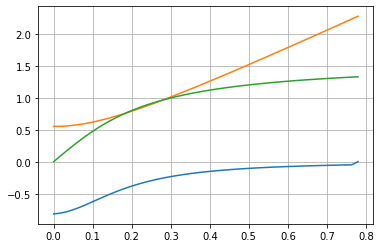

In [15]:
Lambda = 0.45
omega = np.arange(0,5,dOmega)
H = (1-Lambda+Lambda*1j*omega)
G = np.abs(H)
Phi = np.angle(H)
delta = -np.append(np.diff(Phi),0)/dOmega
plt.plot(omega/2/np.pi, delta)
plt.plot(omega/2/np.pi,G)
plt.plot(omega/2/np.pi,Phi)
plt.grid()

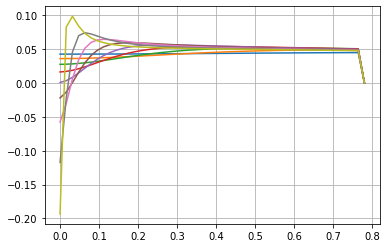

In [16]:
for beta in betas:
    g = beta
    omega = np.arange(0,5,dOmega)
    H = k/(omega*1j+alpha+(k*phi*g/(omega*1j+beta)))
    G = np.abs(H)
    Phi = np.angle(H)
    delta = -np.append(np.diff(Phi),0)/dOmega
    plt.plot(omega/2/np.pi, delta)
plt.grid()

In [17]:
omega

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9])

In [18]:
RL = (-k*g+omega)

In [19]:
betas

array([9.        , 4.        , 2.33333333, 1.5       , 1.        ,
       0.66666667, 0.42857143, 0.25      , 0.11111111])

In [20]:
lambdas

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])